# **HOME LOAN DEFAULTERS PREDICTION**

### **AVULA BHUMIKA**

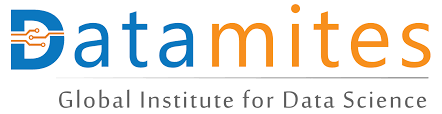

### Load Dependencies

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.ensemble import RandomForestClassifier, StackingClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, RocCurveDisplay
from sklearn.inspection import permutation_importance
from scipy.stats import chi2_contingency, ttest_ind
from imblearn.over_sampling import SMOTE
import matplotlib.pyplot as plt
import seaborn as sns
from warnings import filterwarnings
filterwarnings('ignore')

pd.set_option('display.max_columns', None)
sns.set(style='whitegrid')

Dataset shape: (307511, 122)

Column Data Types:
 float64    65
int64      41
object     16
Name: count, dtype: int64

First few rows:
    SK_ID_CURR  TARGET NAME_CONTRACT_TYPE CODE_GENDER FLAG_OWN_CAR  \
0      100002       1         Cash loans           M            N   
1      100003       0         Cash loans           F            N   
2      100004       0    Revolving loans           M            Y   
3      100006       0         Cash loans           F            N   
4      100007       0         Cash loans           M            N   

  FLAG_OWN_REALTY  CNT_CHILDREN  AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  \
0               Y             0          202500.0    406597.5      24700.5   
1               N             0          270000.0   1293502.5      35698.5   
2               Y             0           67500.0    135000.0       6750.0   
3               Y             0          135000.0    312682.5      29686.5   
4               Y             0          121500.0    513000

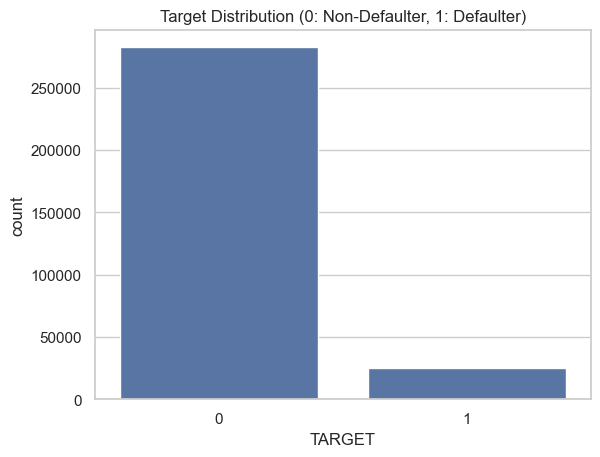


Top missing values:
                           Missing Values  Missing %
COMMONAREA_MEDI                   214865  69.872297
COMMONAREA_AVG                    214865  69.872297
COMMONAREA_MODE                   214865  69.872297
NONLIVINGAPARTMENTS_MEDI          213514  69.432963
NONLIVINGAPARTMENTS_MODE          213514  69.432963
NONLIVINGAPARTMENTS_AVG           213514  69.432963
FONDKAPREMONT_MODE                210295  68.386172
LIVINGAPARTMENTS_MODE             210199  68.354953
LIVINGAPARTMENTS_MEDI             210199  68.354953
LIVINGAPARTMENTS_AVG              210199  68.354953
FLOORSMIN_MODE                    208642  67.848630
FLOORSMIN_MEDI                    208642  67.848630
FLOORSMIN_AVG                     208642  67.848630
YEARS_BUILD_MODE                  204488  66.497784
YEARS_BUILD_MEDI                  204488  66.497784
YEARS_BUILD_AVG                   204488  66.497784
OWN_CAR_AGE                       202929  65.990810
LANDAREA_AVG                      182590  

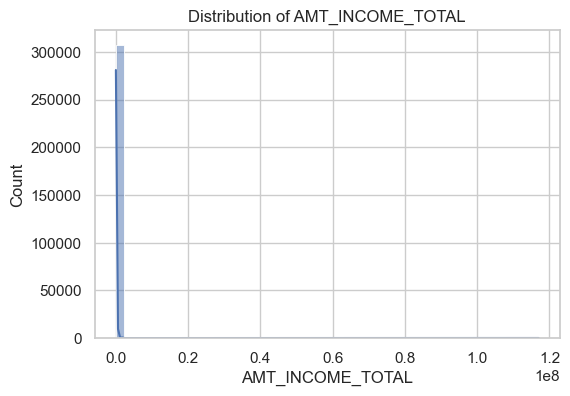

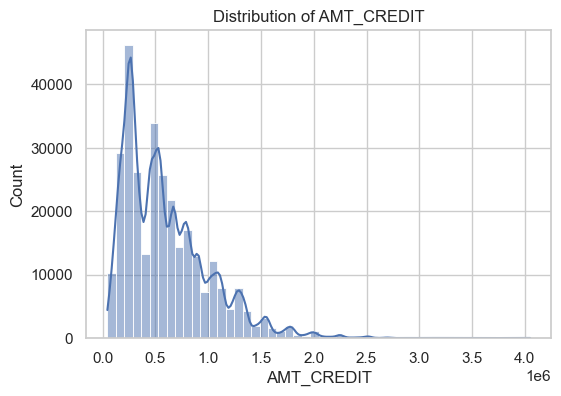

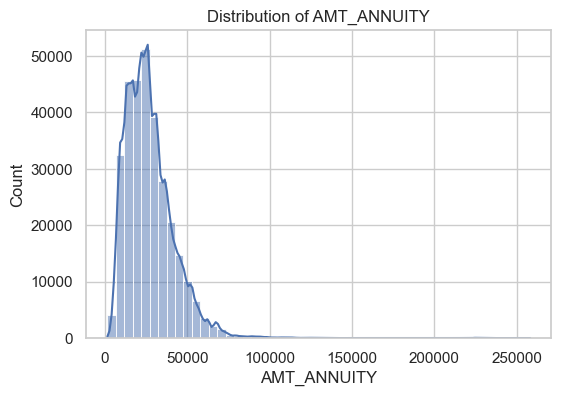

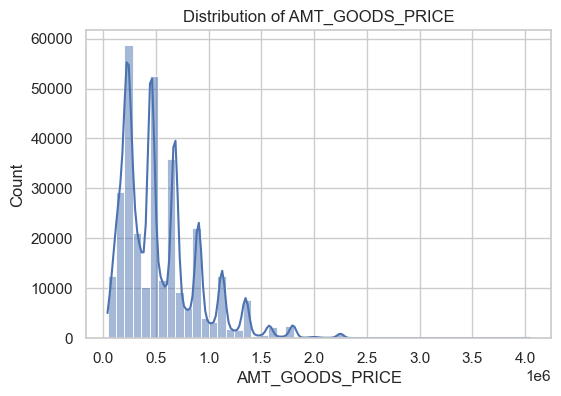

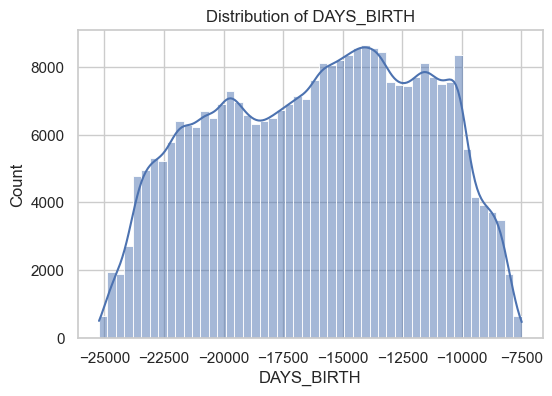

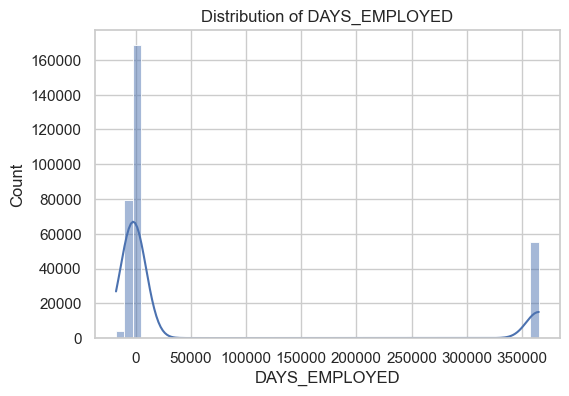

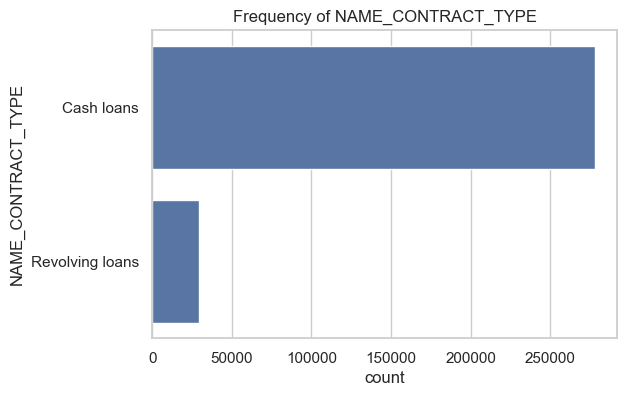

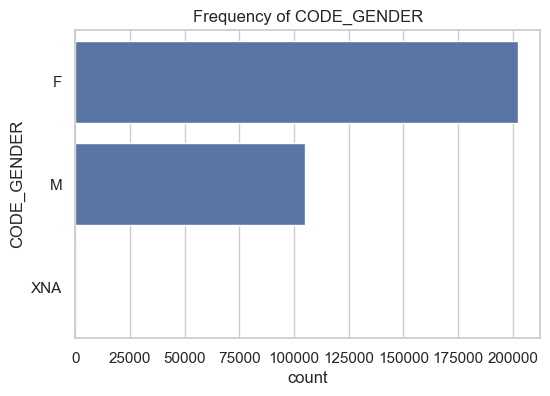

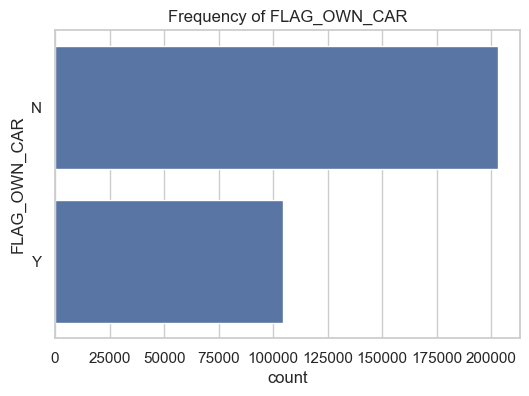

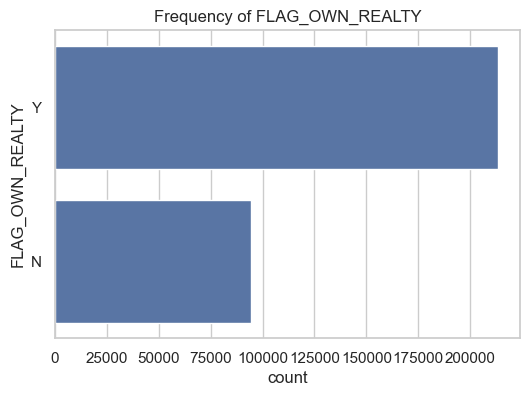

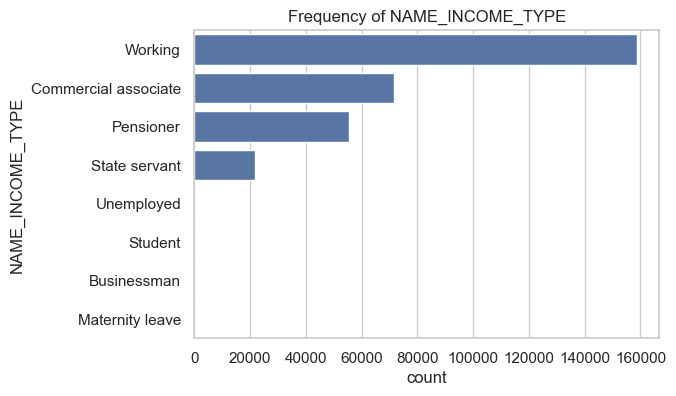

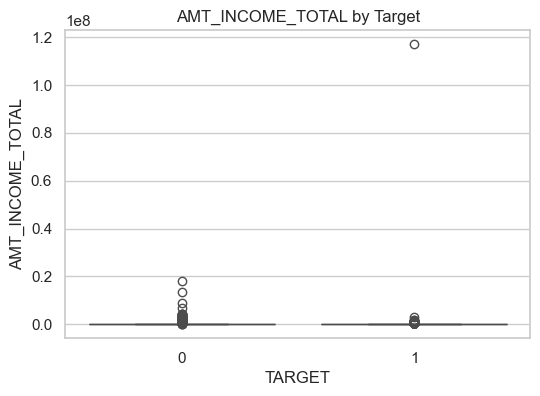

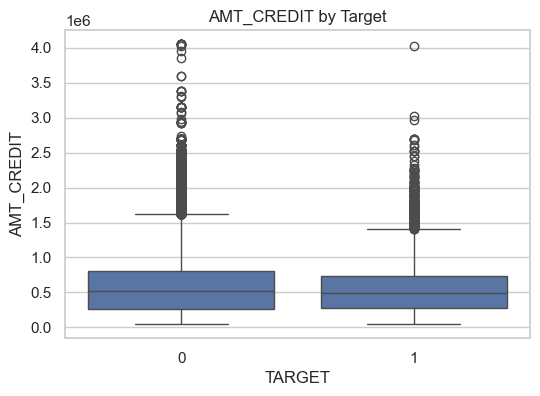

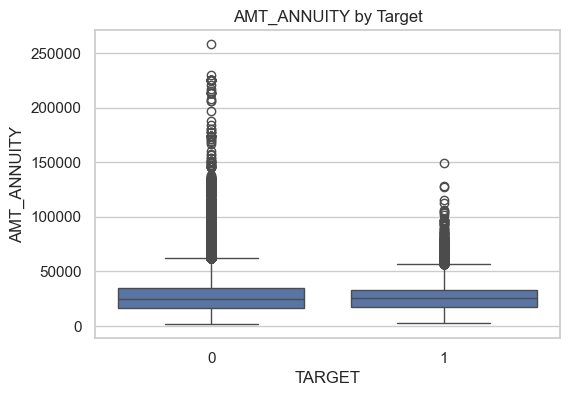

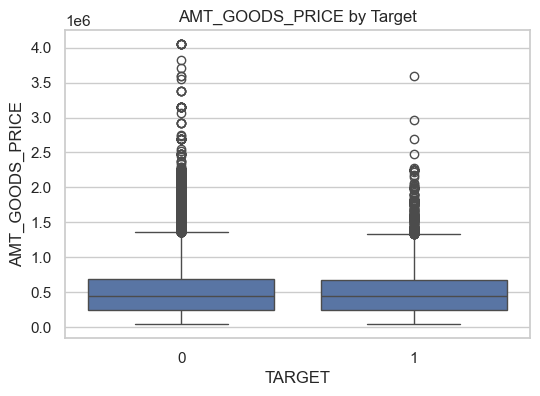

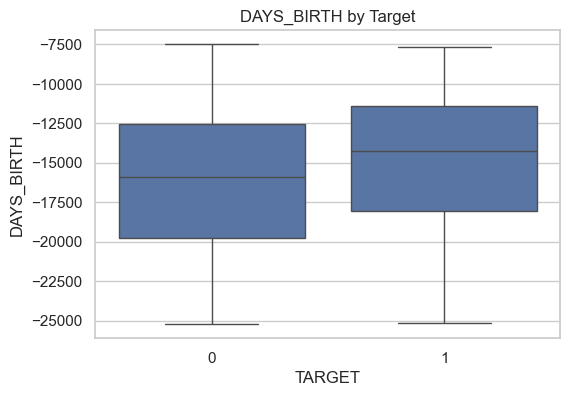

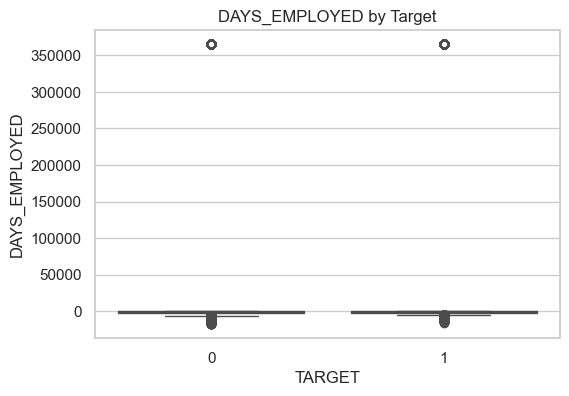

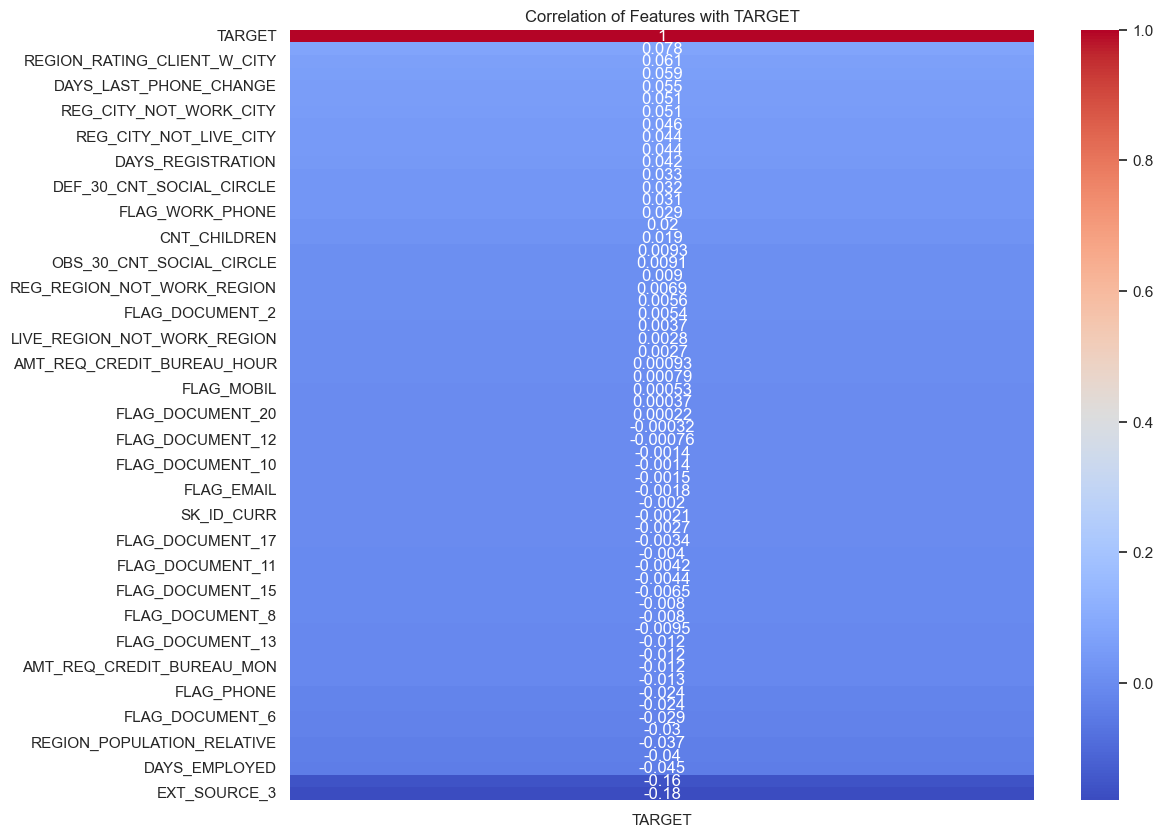

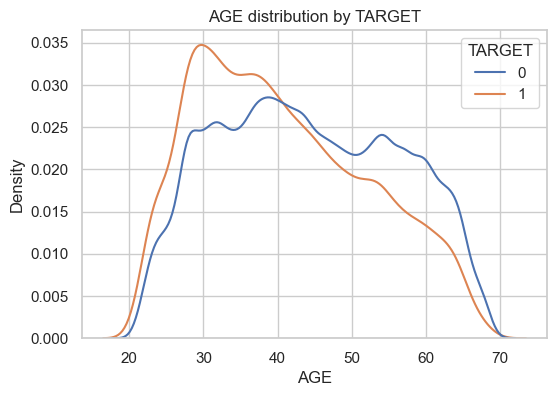

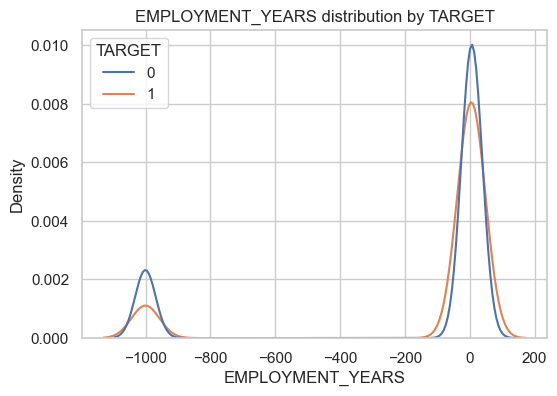

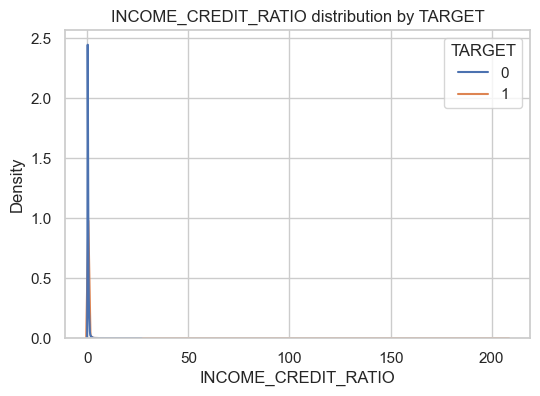

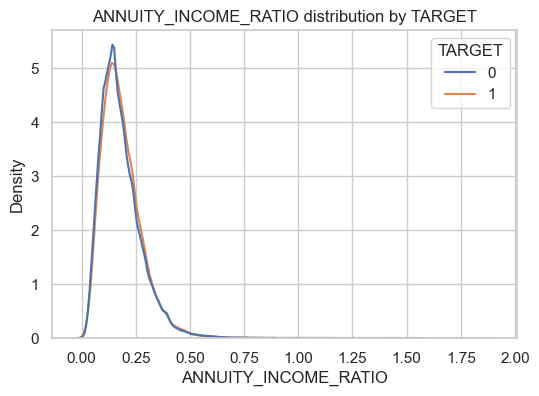

In [3]:
df = pd.read_csv('application_train.csv')

print("Dataset shape:", df.shape)
print("\nColumn Data Types:\n", df.dtypes.value_counts())
print("\nFirst few rows:\n", df.head())

print("\nTarget Value Counts:")
print(df['TARGET'].value_counts(normalize=True))
sns.countplot(x='TARGET', data=df)
plt.title('Target Distribution (0: Non-Defaulter, 1: Defaulter)')
plt.show()

missing = df.isnull().sum()
missing = missing[missing > 0].sort_values(ascending=False)
missing_df = pd.DataFrame({'Missing Values': missing, 'Missing %': 100 * missing / len(df)})
print("\nTop missing values:\n", missing_df.head(20))

threshold = 0.4
cols_to_drop = missing_df[missing_df['Missing %'] > threshold * 100].index
df_clean = df.drop(columns=cols_to_drop)
print(f"\nDropped {len(cols_to_drop)} columns with >40% missing values.")

numerical = df_clean.select_dtypes(include=[np.number])
categorical = df_clean.select_dtypes(exclude=[np.number])

num_cols = ['AMT_INCOME_TOTAL', 'AMT_CREDIT', 'AMT_ANNUITY', 'AMT_GOODS_PRICE', 'DAYS_BIRTH', 'DAYS_EMPLOYED']
for col in num_cols:
    plt.figure(figsize=(6, 4))
    sns.histplot(df_clean[col].dropna(), bins=50, kde=True)
    plt.title(f'Distribution of {col}')
    plt.show()

cat_cols = ['NAME_CONTRACT_TYPE', 'CODE_GENDER', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY', 'NAME_INCOME_TYPE']
for col in cat_cols:
    plt.figure(figsize=(6, 4))
    sns.countplot(y=col, data=df_clean, order=df_clean[col].value_counts().index)
    plt.title(f'Frequency of {col}')
    plt.show()

for col in num_cols:
    plt.figure(figsize=(6, 4))
    sns.boxplot(x='TARGET', y=col, data=df_clean)
    plt.title(f'{col} by Target')
    plt.show()

corr = numerical.corr()
plt.figure(figsize=(12, 10))
sns.heatmap(corr[['TARGET']].sort_values(by='TARGET', ascending=False), annot=True, cmap='coolwarm')
plt.title('Correlation of Features with TARGET')
plt.show()

df_clean['AGE'] = -df_clean['DAYS_BIRTH'] / 365
df_clean['EMPLOYMENT_YEARS'] = -df_clean['DAYS_EMPLOYED'] / 365
df_clean['INCOME_CREDIT_RATIO'] = df_clean['AMT_INCOME_TOTAL'] / df_clean['AMT_CREDIT']
df_clean['ANNUITY_INCOME_RATIO'] = df_clean['AMT_ANNUITY'] / df_clean['AMT_INCOME_TOTAL']

eng_feats = ['AGE', 'EMPLOYMENT_YEARS', 'INCOME_CREDIT_RATIO', 'ANNUITY_INCOME_RATIO']
for col in eng_feats:
    plt.figure(figsize=(6, 4))
    sns.kdeplot(data=df_clean, x=col, hue='TARGET', common_norm=False)
    plt.title(f'{col} distribution by TARGET')
    plt.show()


### Merging Auxilary Data + Feature Engineering

In [6]:
from tqdm import tqdm
import gc

def reduce_memory(df):
    for col in df.select_dtypes(include=['float64']).columns:
        df[col] = pd.to_numeric(df[col], downcast='float')
    for col in df.select_dtypes(include=['int64']).columns:
        df[col] = pd.to_numeric(df[col], downcast='integer')
    return df


def agg_bureau_and_balance(bureau, bureau_balance):
    bb_agg = bureau_balance.groupby('SK_ID_BUREAU').agg({
        'MONTHS_BALANCE': ['min', 'max', 'size'],
        'STATUS': lambda x: x.value_counts().to_dict()
    })
    bb_agg.columns = ['_'.join(col).strip() for col in bb_agg.columns.values]
    bureau = bureau.merge(bb_agg, how='left', on='SK_ID_BUREAU')

    bureau_agg = bureau.groupby('SK_ID_CURR').agg({
        'AMT_CREDIT_SUM': ['mean', 'max', 'sum'],
        'DAYS_CREDIT': ['mean', 'min', 'max'],
        'CREDIT_DAY_OVERDUE': ['mean', 'max'],
        'SK_ID_BUREAU': 'count'
    })
    bureau_agg.columns = ['BUREAU_' + '_'.join(col).strip() for col in bureau_agg.columns.values]
    return reduce_memory(bureau_agg)


def agg_previous_applications(prev):
    prev_agg = prev.groupby('SK_ID_CURR').agg({
        'AMT_APPLICATION': ['mean', 'max', 'min', 'std'],
        'AMT_CREDIT': ['mean', 'max'],
        'CNT_PAYMENT': ['mean', 'max'],
        'RATE_DOWN_PAYMENT': ['mean']
    })
    prev_agg.columns = ['PREV_' + '_'.join(col).strip() for col in prev_agg.columns.values]
    return reduce_memory(prev_agg)


def agg_installments(inst):
    inst['PAYMENT_DIFF'] = inst['AMT_INSTALMENT'] - inst['AMT_PAYMENT']
    inst['DPD'] = inst['DAYS_ENTRY_PAYMENT'] - inst['DAYS_INSTALMENT']
    inst_agg = inst.groupby('SK_ID_CURR').agg({
        'AMT_INSTALMENT': ['mean', 'sum'],
        'AMT_PAYMENT': ['mean', 'sum'],
        'PAYMENT_DIFF': ['mean', 'sum'],
        'DPD': ['mean', 'max']
    })
    inst_agg.columns = ['INST_' + '_'.join(col).strip() for col in inst_agg.columns.values]
    return reduce_memory(inst_agg)


def agg_pos_cash(pos):
    pos_agg = pos.groupby('SK_ID_CURR').agg({
        'MONTHS_BALANCE': ['min', 'max', 'count'],
        'SK_DPD': ['mean', 'max'],
        'SK_DPD_DEF': ['mean', 'max']
    })
    pos_agg.columns = ['POS_' + '_'.join(col).strip() for col in pos_agg.columns.values]
    return reduce_memory(pos_agg)


def agg_credit_card(card):
    card_agg = card.groupby('SK_ID_CURR').agg({
        'AMT_BALANCE': ['mean', 'max'],
        'AMT_CREDIT_LIMIT_ACTUAL': ['mean'],
        'SK_DPD': ['mean', 'max'],
        'SK_DPD_DEF': ['mean', 'max'],
        'MONTHS_BALANCE': ['min', 'max', 'count']
    })
    card_agg.columns = ['CC_' + '_'.join(col).strip() for col in card_agg.columns.values]
    return reduce_memory(card_agg)


if __name__ == "__main__":
    print("Loading base dataset...")
    app = pd.read_csv('application_train.csv')

    print("Processing bureau + bureau_balance...")
    bureau = pd.read_csv('bureau.csv')
    bb = pd.read_csv('bureau_balance.csv')
    bureau_feat = agg_bureau_and_balance(bureau, bb)
    app = app.merge(bureau_feat, on='SK_ID_CURR', how='left')
    del bureau, bb, bureau_feat
    gc.collect()

    print("Processing previous_application...")
    prev = pd.read_csv('previous_application.csv')
    prev_feat = agg_previous_applications(prev)
    app = app.merge(prev_feat, on='SK_ID_CURR', how='left')
    del prev, prev_feat
    gc.collect()

    print("Processing installments_payments...")
    inst = pd.read_csv('installments_payments.csv')
    inst_feat = agg_installments(inst)
    app = app.merge(inst_feat, on='SK_ID_CURR', how='left')
    del inst, inst_feat
    gc.collect()

    print("Processing POS_CASH_balance...")
    pos = pd.read_csv('POS_CASH_balance.csv')
    pos_feat = agg_pos_cash(pos)
    app = app.merge(pos_feat, on='SK_ID_CURR', how='left')
    del pos, pos_feat
    gc.collect()

    print("Processing credit_card_balance...")
    cc = pd.read_csv('credit_card_balance.csv')
    cc_feat = agg_credit_card(cc)
    app = app.merge(cc_feat, on='SK_ID_CURR', how='left')
    del cc, cc_feat
    gc.collect()

    print("Final shape after merges:", app.shape)
    app.to_csv('application_merged.csv', index=False)
    print("Merged dataset saved as application_merged.csv")


Loading base dataset...
Processing bureau + bureau_balance...
Processing previous_application...
Processing installments_payments...
Processing POS_CASH_balance...
Processing credit_card_balance...
Final shape after merges: (307511, 165)
Merged dataset saved as application_merged.csv


In [10]:
import pandas as pd
df=pd.read_csv('application_merged.csv')

In [11]:
len(app.columns) # new dataset

165

In [14]:
len(df.columns) # Old Dataset

165

In [16]:
app['TARGET'].value_counts() # slight increase in target

TARGET
0    282686
1     24825
Name: count, dtype: int64

### Enriched Data Analytics

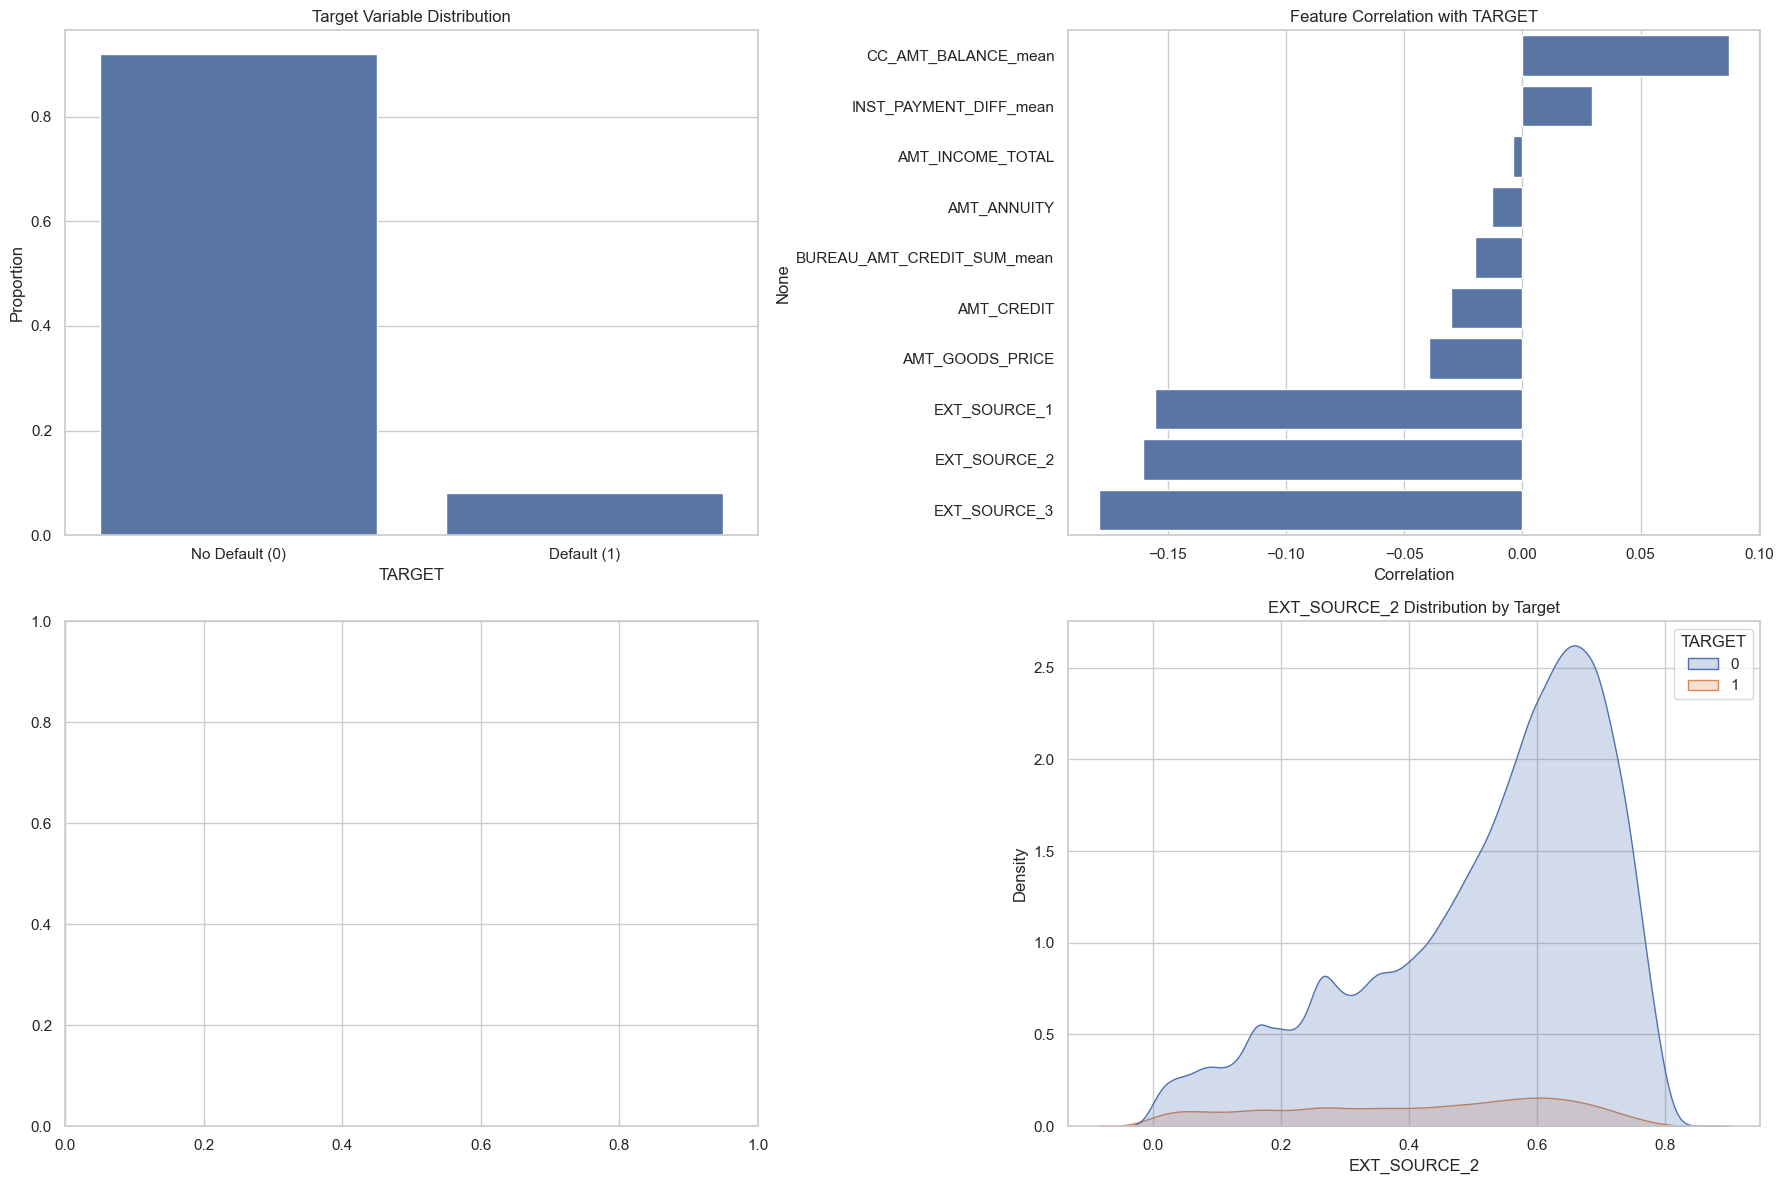

In [19]:
df=app.copy()
target_dist = df['TARGET'].value_counts(normalize=True)
num_cols = ['AMT_INCOME_TOTAL', 'AMT_CREDIT', 'AMT_ANNUITY', 'AMT_GOODS_PRICE', 
            'EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3',
            'BUREAU_AMT_CREDIT_SUM_mean', 'INST_PAYMENT_DIFF_mean', 'CC_AMT_BALANCE_mean']
num_cols = [col for col in num_cols if col in df.columns]

corr_matrix = df[num_cols + ['TARGET']].corr()
target_corr = corr_matrix['TARGET'].drop('TARGET').sort_values(ascending=False)

missing_values = df.isnull().mean().sort_values(ascending=False) * 100
missing_values = missing_values[missing_values > 0]

# Prepare visuals (only a few to keep it concise for now)
fig, axs = plt.subplots(2, 2, figsize=(18, 12))

sns.barplot(x=target_dist.index, y=target_dist.values, ax=axs[0, 0])
axs[0, 0].set_title('Target Variable Distribution')
axs[0, 0].set_xticks([0, 1])
axs[0, 0].set_xticklabels(['No Default (0)', 'Default (1)'])
axs[0, 0].set_ylabel('Proportion')

sns.barplot(x=target_corr.values, y=target_corr.index, ax=axs[0, 1])
axs[0, 1].set_title('Feature Correlation with TARGET')
axs[0, 1].set_xlabel('Correlation')


if 'EXT_SOURCE_2' in df.columns:
    sns.kdeplot(data=df, x='EXT_SOURCE_2', hue='TARGET', fill=True, ax=axs[1, 1])
    axs[1, 1].set_title('EXT_SOURCE_2 Distribution by Target')

plt.tight_layout()
plt.show()

### Statistical Testing and Model Building

Classification Report:
               precision    recall  f1-score   support

           0       0.92      0.95      0.93     84806
           1       0.10      0.07      0.08      7448

    accuracy                           0.88     92254
   macro avg       0.51      0.51      0.51     92254
weighted avg       0.85      0.88      0.87     92254

Confusion Matrix:
 [[80463  4343]
 [ 6963   485]]
ROC AUC Score:  0.580258861426647


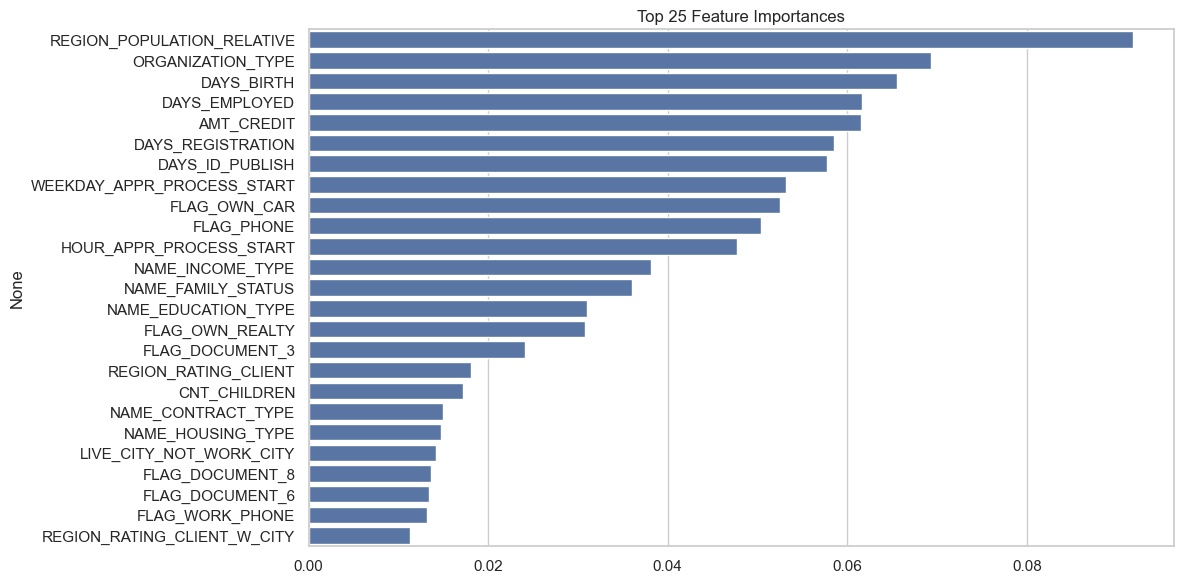

In [22]:
target_col = 'TARGET'
X = df.drop(columns=[target_col])
y = df[target_col]

cat_cols = X.select_dtypes(include='object').columns.tolist()
num_cols = X.select_dtypes(include=np.number).columns.tolist()

significant_cat_cols = []
for col in cat_cols:
    if df[col].isnull().sum() == 0:
        contingency = pd.crosstab(df[col], y)
        chi2, p, _, _ = chi2_contingency(contingency)
        if p < 0.05:
            significant_cat_cols.append(col)

significant_num_cols = []
for col in num_cols:
    if df[col].isnull().sum() == 0:
        group0 = df[df[target_col] == 0][col]
        group1 = df[df[target_col] == 1][col]
        stat, p = ttest_ind(group0, group1, equal_var=False)
        if p < 0.05:
            significant_num_cols.append(col)

final_features = significant_cat_cols + significant_num_cols
X_selected = df[final_features]

for col in significant_cat_cols:
    le = LabelEncoder()
    X_selected[col] = le.fit_transform(X_selected[col].astype(str))

X_train, X_test, y_train, y_test = train_test_split(X_selected, y, test_size=0.3, stratify=y, random_state=42)

smote = SMOTE(random_state=42)
X_res, y_res = smote.fit_resample(X_train, y_train)

clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(X_res, y_res)
y_pred = clf.predict(X_test)
y_prob = clf.predict_proba(X_test)[:, 1]

print("Classification Report:\n", classification_report(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("ROC AUC Score: ", roc_auc_score(y_test, y_prob))


importances = clf.feature_importances_
feature_imp = pd.Series(importances, index=X_selected.columns).sort_values(ascending=False)

plt.figure(figsize=(12, 6))
sns.barplot(x=feature_imp.values[:25], y=feature_imp.index[:25])
plt.title("Top 25 Feature Importances")
plt.tight_layout()
plt.show()


## Hyperparameter Tuning

Classification Report:
               precision    recall  f1-score   support

           0       0.92      0.99      0.95     56538
           1       0.31      0.05      0.09      4965

    accuracy                           0.91     61503
   macro avg       0.62      0.52      0.52     61503
weighted avg       0.87      0.91      0.89     61503

Confusion Matrix:
 [[55962   576]
 [ 4705   260]]
ROC AUC Score:  0.6729371688344287


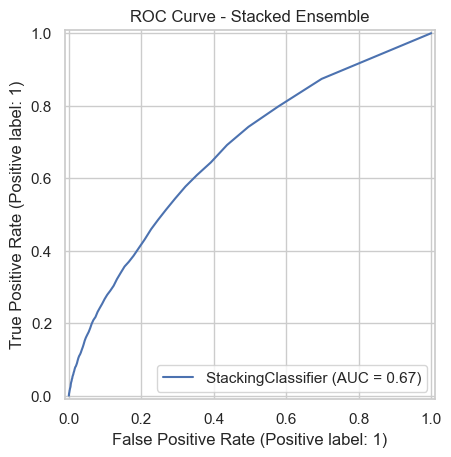

In [25]:
target = 'TARGET'
categorical_cols = ['NAME_CONTRACT_TYPE','FLAG_OWN_CAR' ,'CODE_GENDER', 'NAME_INCOME_TYPE', 'NAME_EDUCATION_TYPE', 
                    'NAME_FAMILY_STATUS', 'NAME_HOUSING_TYPE', 'ORGANIZATION_TYPE', 'WEEKDAY_APPR_PROCESS_START']
numerical_cols = ['AMT_CREDIT', 'REGION_POPULATION_RELATIVE','DAYS_ID_PUBLISH','DAYS_REGISTRATION','AMT_ANNUITY', 
                  'EXT_SOURCE_2', 'EXT_SOURCE_3', 'FLAG_PHONE','CNT_CHILDREN','DAYS_BIRTH', 'DAYS_EMPLOYED', 'BUREAU_DAYS_CREDIT_mean', 'PREV_AMT_CREDIT_mean', 
                  'INST_AMT_PAYMENT_mean', 'CC_AMT_BALANCE_mean']  

df_encoded = df.copy()
for col in categorical_cols:
    if df_encoded[col].dtype == 'object':
        le = LabelEncoder()
        df_encoded[col] = le.fit_transform(df_encoded[col].astype(str))

X = df_encoded[categorical_cols + numerical_cols]
y = df_encoded[target]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, stratify=y, test_size=0.2, random_state=42
)

scale_pos_weight = (y_train == 0).sum() / (y_train == 1).sum()

rf = RandomForestClassifier(n_estimators=100, random_state=42, class_weight='balanced', n_jobs=-1)
xgb = XGBClassifier(n_estimators=100, random_state=42, scale_pos_weight=scale_pos_weight, use_label_encoder=False, eval_metric='logloss')
lgbm = LGBMClassifier(n_estimators=100, random_state=42, scale_pos_weight=scale_pos_weight)

estimators = [
    ('rf', rf),
    ('xgb', xgb),
    ('lgbm', lgbm)
]

stacked_clf = StackingClassifier(
    estimators=estimators,
    final_estimator=RandomForestClassifier(n_estimators=100, random_state=42, class_weight='balanced'),
    cv=5,
    n_jobs=-1
)

stacked_clf.fit(X_train, y_train)

y_pred = stacked_clf.predict(X_test)
y_proba = stacked_clf.predict_proba(X_test)[:, 1]

print("Classification Report:\n", classification_report(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("ROC AUC Score: ", roc_auc_score(y_test, y_proba))

RocCurveDisplay.from_estimator(stacked_clf, X_test, y_test)
plt.title("ROC Curve - Stacked Ensemble")
plt.show()


## V2 Improvements

Classification Report:
               precision    recall  f1-score   support

           0       0.92      0.99      0.95     56538
           1       0.30      0.05      0.09      4965

    accuracy                           0.91     61503
   macro avg       0.61      0.52      0.52     61503
weighted avg       0.87      0.91      0.88     61503

Confusion Matrix:
 [[55943   595]
 [ 4711   254]]
ROC AUC Score:  0.6779966557796756


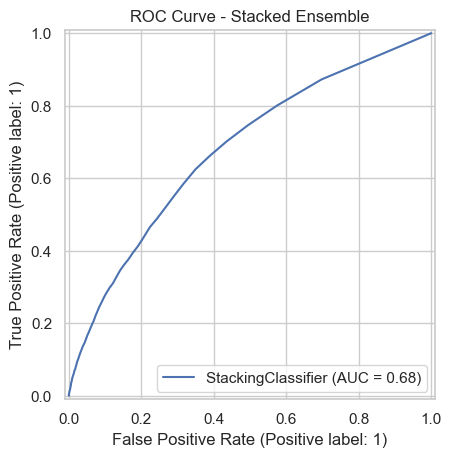

[LightGBM] [Info] Number of positive: 19860, number of negative: 226148
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.010557 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3203
[LightGBM] [Info] Number of data points in the train set: 246008, number of used features: 24
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.080729 -> initscore=-2.432482
[LightGBM] [Info] Start training from score -2.432482


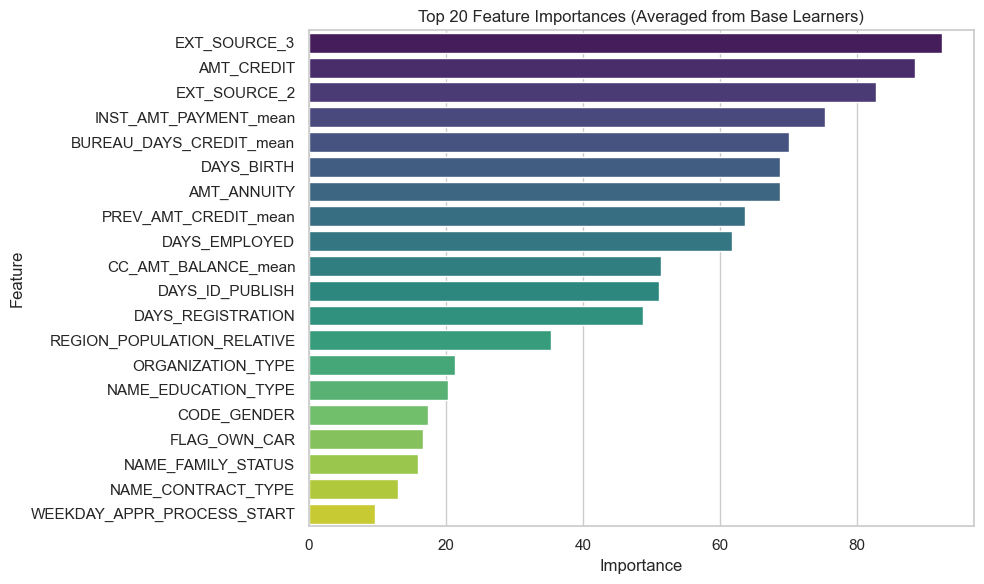

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)

scale_pos_weight = (y_train == 0).sum() / (y_train == 1).sum()

rf = RandomForestClassifier(n_estimators=100, random_state=42, class_weight='balanced', n_jobs=-1)
xgb = XGBClassifier(n_estimators=100, random_state=42, scale_pos_weight=scale_pos_weight, use_label_encoder=False, eval_metric='logloss')
lgbm = LGBMClassifier(n_estimators=100, random_state=42, scale_pos_weight=scale_pos_weight)

estimators = [('rf', rf), ('xgb', xgb), ('lgbm', lgbm)]
stacked_clf = StackingClassifier(
    estimators=estimators,
    final_estimator=RandomForestClassifier(n_estimators=100, random_state=42, class_weight='balanced'),
    cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=42),
    n_jobs=-1
)

stacked_clf.fit(X_train, y_train)

y_pred = stacked_clf.predict(X_test)
y_proba = stacked_clf.predict_proba(X_test)[:, 1]

print("Classification Report:\n", classification_report(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("ROC AUC Score: ", roc_auc_score(y_test, y_proba))

RocCurveDisplay.from_estimator(stacked_clf, X_test, y_test)
plt.title("ROC Curve - Stacked Ensemble")
plt.show()

rf.fit(X_train, y_train)
xgb.fit(X_train, y_train)
lgbm.fit(X_train, y_train)

importances = (rf.feature_importances_ + xgb.feature_importances_ + lgbm.feature_importances_) / 3
feature_importance_df = pd.DataFrame({
    'Feature': X.columns,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(data=feature_importance_df.head(20), x='Importance', y='Feature', palette='viridis')
plt.title("Top 20 Feature Importances (Averaged from Base Learners)")
plt.tight_layout()
plt.show()

perm_result = permutation_importance(stacked_clf, X_test, y_test, n_repeats=10, random_state=42, n_jobs=-1)

perm_importance_df = pd.DataFrame({
    'Feature': X.columns,
    'Importance': perm_result.importances_mean
}).sort_values(by='Importance', ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(data=perm_importance_df.head(20), x='Importance', y='Feature', palette='magma')
plt.title("Top 20 Feature Importances (Permutation on Stacked Model)")
plt.tight_layout()
plt.show()
